In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
first_day=session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date).first()
print("The first day is in datasource is "+str(first_day))
last_day=session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).first()
print("The last day is in datasource is "+str(last_day))

The first day is in datasource is ('2010-01-01',)
The last day is in datasource is ('2017-08-23',)


In [14]:
travel_date = dt.date(2017, 8, 23)
print("The travel date is "+str(travel_date))
last_12_month_date = dt.date(2016, 8, 23)
print("The last 12 months date is "+str(last_12_month_date))

The travel date is 2017-08-23
The last 12 months date is 2016-08-23


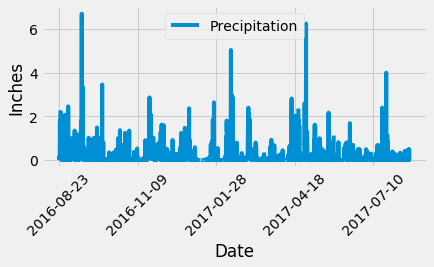

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>'2016-08-22').order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)
plt.tight_layout()
plt.ylabel('Inches')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


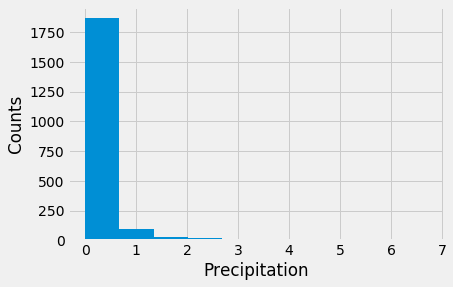

The mean of Precipitation is 0.17727857496288968
The median of Precipitation is 0.02
The mode of Precipitation is 0    0.0
dtype: float64
NormaltestResult(statistic=nan, pvalue=nan)


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
import scipy.stats as sts
plt.hist(df['Precipitation'])
plt.xlabel('Precipitation')
plt.ylabel('Counts')
plt.show()
print("The mean of Precipitation is "+str(df['Precipitation'].mean()))
print("The median of Precipitation is "+str(df['Precipitation'].median()))
print("The mode of Precipitation is "+str(df['Precipitation'].mode()))
print(sts.normaltest(df["Precipitation"].sample(100)))

In [17]:
quartiles = df['Precipitation'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Precipitation is: {lowerq}")
print(f"The upper quartile of Precipitation is: {upperq}")
print(f"The interquartile range of Precipitation is: {iqr}")
print(f"The the median of Precipitation is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of Precipitation is: 0.0
The upper quartile of Precipitation is: 0.13
The interquartile range of Precipitation is: 0.13
The the median of Precipitation is: 0.02 
Values below -0.195 could be outliers.
Values above 0.325 could be outliers.


In [18]:
# Design a query to show how many stations are available in this dataset?
num_station=session.query(Measurement.station).group_by(Measurement.station).count()
print(f"The number of stations is {num_station}")

The number of stations is 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_effective_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for i in most_effective_station:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
#the name of most effective station is 
names=session.query(Measurement.station,Station.name).filter(Measurement.station=='USC00519281').group_by(Measurement.station).all()
name=[i[1] for i in names]
print(f"The most effective station name is {name}")

The most effective station name is ['WAIKIKI 717.2, HI US']


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_effecive_id='USC00519281'
lowest_temperature = session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
print(f"The lowest tem of most effective station is {lowest_temperature}")
highest_temperature = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
print(f"The highest tem of most effective station is {highest_temperature}")
average_temperature = session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
print(f"The average tem of most effective station is {average_temperature}")

The lowest tem of most effective station is [(54.0,)]
The highest tem of most effective station is [(85.0,)]
The average tem of most effective station is [(71.66378066378067,)]


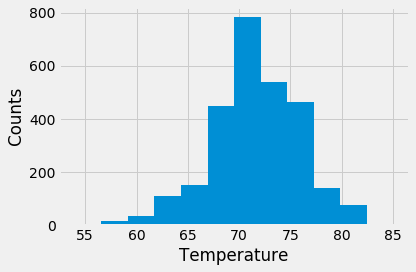

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results2 = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281')
tobs=[i[0] for i in results2]

plt.hist(tobs,bins=12)
plt.xlabel('Temperature')
plt.ylabel('Counts')
#plt.legend('tobs')
plt.tight_layout()
plt.show()